# Mosquito Sink/Source/Bridge Detection

# Setup

In [1]:
import pandas as pd
import numpy as np

In [2]:
transitions = pd.read_csv('../dev/kernels/kernel_regular_5000.csv', header=None)
locations = pd.read_csv('../dev/data_509/stp_all_sites_v3.csv')

# A Peek at the Data

In [3]:
display(transitions.shape, transitions.head())

(509, 509)

0       1       2       3       4       5       6       7       8    \
0  0.7980  0.0060  0.0050  0.0035  0.0075  0.0010  0.0030  0.0030  0.0010   
1  0.0060  0.7465  0.0145  0.0120  0.0070  0.0035  0.0035  0.0055  0.0030   
2  0.0050  0.0145  0.7540  0.0160  0.0070  0.0040  0.0045  0.0070  0.0015   
3  0.0035  0.0120  0.0160  0.7705  0.0035  0.0060  0.0035  0.0025  0.0045   
4  0.0075  0.0070  0.0070  0.0035  0.7535  0.0035  0.0040  0.0015  0.0035   

      9    ...  499  500  501  502  503  504  505  506  507  508  
0  0.0010  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0050  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0035  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0035  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0060  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 509 columns]

In [4]:
display(locations.shape, locations.head())

(509, 3)

lon      lat  pop
0  7.42917  1.61930  222
1  7.41421  1.63409   12
2  7.41390  1.63602    8
3  7.41219  1.63492   16
4  7.42591  1.64041   23

# The Detector Class - Example Usage

In [5]:
import sys
sys.path.insert(0, '../dev/')
import ssbplots as cp
import detector

In [6]:
d = detector.Detector(transitions, 
                      locations,
                      ss_vals=10000,
                      n_clusters=8, 
                      random_state=0)

In [7]:
# At what step is the system is steady-state?
d.ss_step

1090

In [8]:
# Let's verify that this is steady state using the default tolerance
np.all(np.abs(d.migrate(d.ss_step) - d.migrate(d.ss_step + 1)) <= 0.05)

True

In [9]:
# If we start at time step 0, what happens at steady-state?
d.run()
display(d.ndata().head(),\
        d.cdata().head()
)

lon      lat  pop  cid   ctype
0  7.42917  1.61930  222    1  bridge
1  7.41421  1.63409   12    1  bridge
2  7.41390  1.63602    8    1  bridge
3  7.41219  1.63492   16    1  bridge
4  7.42591  1.64041   23    1  bridge

num_in       num_out    prp_in   prp_out    type
cid                                                        
0    23310.858604   7001.288445  0.769027  0.230973    sink
1     3219.559067   3219.559067  0.500000  0.500000  bridge
2     3759.208046    589.135379  0.864515  0.135485    sink
3    12138.970275  10882.743881  0.527284  0.472716  bridge
4     7531.400855    524.250871  0.934921  0.065079    sink

In [10]:
# The entries below should only slightly change
d.run(0, d.ss_step + 5).cdata().head()

num_in       num_out    prp_in   prp_out    type
cid                                                        
0    23310.212984   7001.427613  0.769019  0.230981    sink
1     3219.559346   3219.559346  0.500000  0.500000  bridge
2     3761.072695    588.799568  0.864640  0.135360    sink
3    12138.683878  10882.818021  0.527276  0.472724  bridge
4     7532.235123    524.103885  0.934945  0.065055    sink

In [11]:
# What happens if we stop before steady-state?
d.run(0, 100).cdata().head()

num_in       num_out    prp_in   prp_out    type
cid                                                        
0    25232.620558   6575.588699  0.793274  0.206726    sink
1     3194.638859   3194.638859  0.500000  0.500000  bridge
2     1400.113013    990.928972  0.585566  0.414434  bridge
3     9985.642378  11205.187508  0.471225  0.528775  bridge
4     5001.859194   1095.721061  0.820302  0.179698    sink

In [12]:
# What happens from time step 1000 to steady-state?
d.run(1000).cdata().head()

num_in    num_out  prp_in  prp_out    type
cid                                               
0     0.000000  16.609620     0.0      1.0  source
1     0.019892   0.019892     0.5      0.5  bridge
2    46.190527   0.000000     1.0      0.0    sink
3     0.000000   7.001308     0.0      1.0  source
4    20.526715   0.000000     1.0      0.0    sink

In [13]:
# How many bridges, sinks, and sources do we have?
d.cdata().groupby('type').size()

type
bridge    1
sink      2
source    5
dtype: int64

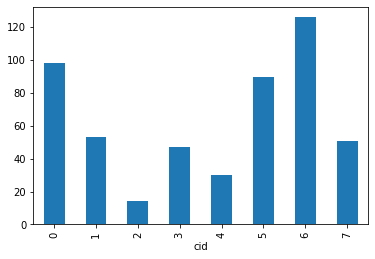

In [14]:
# What are the sizes of each community?
d.ndata().groupby('cid').size().plot(kind='bar');

# Plots

### First, let's see where the data is geographically:

In [15]:
import folium
import folium.plugins

In [16]:
COORDS = (7.42917, 1.61930)
folimp = folium.Map(locations=COORDS, zoom_start=13)
points = locations[['lat', 'lon']].astype('float').values
heatmp = folium.plugins.HeatMap(points.tolist(), radius=10)
folimp.add_child(heatmp)

In [17]:
cluster = folium.plugins.MarkerCluster()
for _, r in locations[['lat', 'lon']].iterrows():
    cluster.add_child(folium.Marker([float(r['lat']), float(r['lon'])]))
folimp = folium.Map(locations=COORDS, zoom_start=13)
folimp.add_child(cluster)
folimp

In [18]:
# Looks like there are two islands that are independent. Let's split 
# them up, and analyze each individually:
d.run()
nodes = d.ndata()
comms = d.cdata()

principe_locs = nodes[nodes['lat'] > 1.25]
principe_tmtx = transitions.iloc[principe_locs.index, principe_locs.index]
principe_coms = comms[comms.index.isin(principe_locs['cid'].unique())]

sao_tome_locs = nodes[nodes['lat'] < 0.50]
sao_tome_tmtx = transitions.iloc[sao_tome_locs.index, sao_tome_locs.index]
sao_tome_coms = comms[comms.index.isin(sao_tome_locs['cid'].unique())]

### Now let's use a graph to visualize the network:

In [19]:
import matplotlib.cm as cmx
import geojson

# To plot a background, convert the SHP file(s) to a geojson file
# Use: https://mygeodata.cloud/converter/shp-to-geojson
with open("geojson/STP.geojson") as json_file:
    json_data = geojson.load(json_file)
    
sao_tome_geo = [json_data['features'][1]]
principe_geo = [json_data['features'][0]]
both_loc_geo = json_data['features']

In [20]:
# This will add nonnegative Gaussian noise to the edges
def jitter_edges(weights, mean=0, stddev=1):
    return weights + np.abs(np.random.normal(mean, stddev, size=len(weights)))

In [21]:
# Create copies for exploration
st_locs = sao_tome_locs.copy()
p_locs = principe_locs.copy()

In [25]:
# Get location populations at steady state
st_locs['pop'] = d.migrate(d.ss_step)[sao_tome_locs.index]

cp.plot_network(sao_tome_tmtx.values, st_locs,
                nodes_cm=cmx.get_cmap('cool')   , nodes_cb=False,
                edges_cm=cmx.get_cmap('Purples'), edges_cb=True,
                bordr_cm=cmx.get_cmap('gray')   , bordr_cb=True,
                cb_xlocs=[1.02, 1.15],
                min_prob=0.005,
                edges_fn=jitter_edges,
                geo_data=sao_tome_geo,
                fig_wdth=650, fig_hght=600)

In [26]:
# Get location populations at steady state
p_locs['pop'] = d.migrate(d.ss_step)[principe_locs.index]
    
cp.plot_network(principe_tmtx.values, p_locs,
                nodes_cm=cmx.get_cmap('cool')   , nodes_cb=False,
                edges_cm=cmx.get_cmap('Purples'), edges_cb=True,
                bordr_cm=cmx.get_cmap('flag')   , bordr_cb=False,
                cb_xlocs=[1.02, 1.15],
                min_prob=0.005, 
                edges_fn=jitter_edges,
                geo_data=principe_geo,
                fig_wdth=750, fig_hght=600)